# Calculating Distances Between Graphs with Time Series of Graph Laplacians using Matrix Logs

## I. Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import networkx as nx
from scipy.linalg import logm, expm
from numpy import linalg as lg
from sklearn.neighbors import kneighbors_graph
from scipy.spatial import distance

## II. Functions for Simulating Time Series

### A. Generate Points and Graph
https://stackoverflow.com/questions/62500289/get-random-points-at-edges-of-a-square-in-python

In [2]:
def generate_points(n = 100, a = 1, b = -1, dim = 2, dist = 'uniform'):
    """Generate points from distribution
    Parameters:
        n: number of points
        a: upper bound
        b: lower bound
        dim (d): dimension of orientation of points (i.e. 2d, sphere, 4d square, etc.)
        dist: distribution sampled from
    Returns:
        d by n list of arrays of points from distribution
    """
    points = []
    if dist == 'uniform':
        for i in range(dim):
            # Random coordinates [b,a) uniform distributed
            points.append((b - a) *  np.random.random_sample((n,)) + a)
    
        if dim == 2:
            # Create limits (x,y)=((b,a),(b,a))
            plt.xlim((b,a))
            plt.ylim((b,a))

            # Plot points
            for i in range(n):
                plt.plot(points[0], points[1], 'ro', color = "C0")
            plt.show()
    return points

A (connection matrix) is not symmetric, some nodes are the closest neighbors of other nodes but the inverse is not always true. 

Not the same as adjacency matrix--connection matrix is not symmetric, adjacency matrix is.

**Question:** If connectivity matrix all sums to 20, why does graph not sum to 20? is connectivity matrix same as adjacency matrix?

**Answer:** Adjacency matrix is symmetrizing the matrix, so some nodes will have additional edges if they are another node’s nearest neighbor but that node is not their nearest neighbor (may not sum to 20)

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html

Adjacency matrix is symmetric

**Question:** include_self to true or false??? if change to false would need to change logic in adding/removing edge...changes how counts number of neighbors.

**Answer:** keep consistently as true for distance and connectivity

set k = N/5

In [3]:
def points_to_graph_mat(points, num_neigh = int(100/5), kind = 'connectivity', include_self_neigh = True,
                        debug = True, **kwargs):
    """
    Generate connection matrix or connection distance matrix for given points.
    Parameters:
        points: d by n list of arrays of points from distribution
        num_neigh: number of neighbors in kneighbors graph (default is N/5)
        kind: 'connectivity' or 'distance', from kneighbors_graph mode
        include_self_neigh: True or False, from kneighbors_graph include_self
        debug: True will print intermediate steps
        kwargs (from `cdist`)
            metric: from cdist, default 'minkowski'
            p: from cdist, default p = 2
    Returns:
         n by n sparse matrix returned from kneighbors_graph
    """
    if kind == 'connectivity':
        X = np.array(points).T
        mat = kneighbors_graph(X, n_neighbors = num_neigh, mode=kind, include_self=include_self_neigh)
        #laplacian will be positive definite either way
        if debug == True:
            print(mat.toarray()) #connection matrix
    elif kind == 'distance':
        mat = distance.cdist(list(zip(*points)), list(zip(*points)), **kwargs)
        if debug == True:
            print(mat) #distance matrix, constant through time series
    return mat

def plot_graph(G, points, font_size = 8, node_color = None):
    """
    Plots graph with labels and coloring
    Parameters:
        G: networkx Graph object if already have graph
        points: d by n list of arrays of points from distribution (for plotting the graph)
    """
    pos = dict(zip(G.nodes(), zip(*points)))
    fig, ax = plt.subplots()
    nx.draw(G, pos=pos, node_size = 25, ax=ax, with_labels=True, font_size=font_size, node_color = node_color)
    limits=plt.axis('on') # turns on axis
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.show()

def generate_graph(connection_mat = None, show_plot = True, from_graph = False, debug = True, **kwargs):
    """
    Generate a graph from a given connection matrix or graph G
    Parameters:
        connection_mat: n by n sparse matrix returned from kneighbors_graph in points_to_graph_mat, connectivity mode.
        show_plot: True will output plot of graph, False will not plot
        from_graph: False will use connection matrix.
            True will use existing graph to plot and generate laplacian and adjacency matrix.
        debug: True will print intermediate steps
        kwargs (from `plot_graph`):
            G: networkx Graph object if already have graph
            points: d by n list of arrays of points from distribution (for plotting the graph)
    Returns:
        G, laplacian matrix, adjacency matrix
    """
    if from_graph == False:
        G = nx.from_scipy_sparse_matrix(connection_mat)
        if show_plot == True:
            plot_graph(G, **kwargs)
        lap_mat = nx.laplacian_matrix(G)
        adj_mat = nx.adjacency_matrix(G)
        if debug == True:
            print(lap_mat.toarray())
            print(adj_mat.toarray())
        return G, lap_mat, adj_mat
    # use provided graph G
    else:
        if show_plot == True:
            plot_graph(**kwargs)
        lap_mat = nx.laplacian_matrix(kwargs['G'])
        adj_mat = nx.adjacency_matrix(kwargs['G'])
        if debug == True:
            print(lap_mat.toarray())
            print(adj_mat.toarray())
        return kwargs['G'], lap_mat, adj_mat

### B. Randomly Add or Remove Edge in Loop of Time Series

In [4]:
def remove_one_edge(last_G, debug = True):
    """
    Randomly remove an edge (except for diagonals) from the given graph, last_G
    Parameters:
        last_G: networkx Graph object
        debug: True will print intermediate steps
    Returns:
        new_G, color_map
    """
    temp = nx.adjacency_matrix(last_G).toarray() #do not change diagonal entries, change diagonals to -1
    np.fill_diagonal(temp, -1)
    ones_adj = np.where(temp == 1)
    change_one = np.random.randint(0, len(ones_adj[0]))
    # change 1 to 0
    temp1 = nx.adjacency_matrix(last_G).toarray()
    temp1[ones_adj[0][change_one], ones_adj[1][change_one]] = 0
    temp1[ones_adj[1][change_one], ones_adj[0][change_one]] = 0
    if debug == True:
        print("Remove: ", str(ones_adj[0][change_one]), " , ", str(ones_adj[1][change_one]))
    # orange for removing edge
    color_map = ['C0' if (node != ones_adj[0][change_one]) & (node != ones_adj[1][change_one]) else 'C1' for node in last_G]
    # make new graph
    new_G = nx.from_numpy_array(temp1)
    return new_G, color_map

def add_one_edge(last_G, connection_mat_dist, threshold = 0.5, debug = True):
    """
    Randomly add an edge from the given graph, last_G, if the distance is smaller than some threshold.
    If no unconnected nodes are within the distance threshold, randomly add an edge.
    Parameters:
        last_G: networkx Graph object
        connection_mat_dist: n by n sparse matrix returned from kneighbors_graph in points_to_graph_mat, distance mode.
        threshold: how close points need to be to add an edge
        debug: True will print intermediate steps
    Returns:
        new_G, color_map
    """
    # change entry with no edge but distance is also small
    # distance matrix from kneighbors_graph has 0 if not neighbors, does not have actual distance between points
        # use scipy.spatial.distance.cdist instead
    zeros_adj = np.where((nx.adjacency_matrix(last_G).toarray() == 0) & 
                         ((connection_mat_dist < threshold) & (connection_mat_dist > 0)))
    if(len(zeros_adj[0]) == 0):
        # if distance is too large just choose any two nodes where there is not an edge
        zeros_adj = np.where((nx.adjacency_matrix(last_G).toarray() == 0))
        if debug == True:
            print('random add')
    change_zero = np.random.randint(0, len(zeros_adj[0]))
    # change 0 to 1
    temp0 = nx.adjacency_matrix(last_G).toarray()
    temp0[zeros_adj[0][change_zero], zeros_adj[1][change_zero]] = 1
    temp0[zeros_adj[1][change_zero], zeros_adj[0][change_zero]] = 1
    if debug == True:
        print("Add: " + str(zeros_adj[0][change_zero]), " , ", str(zeros_adj[1][change_zero]))
        print('Distance_1: ', connection_mat_dist[zeros_adj[0][change_zero], zeros_adj[1][change_zero]])
        print('Distance_2: ', connection_mat_dist[zeros_adj[1][change_zero], zeros_adj[0][change_zero]])
    # red for adding an edge
    color_map = ['C0' if (node != zeros_adj[0][change_zero]) & (node != zeros_adj[1][change_zero]) 
                 else 'C3' for node in last_G]
    # make new graph
    new_G = nx.from_numpy_array(temp0)
    return new_G, color_map

In [5]:
def generate_graph_time_series(initial_G, ts_dict, points, connection_mat_dist, start, end, debug = True,
                               threshold = 0.6, show_plot = True, **kwargs):
    """
    Returns a dictionary of the time series of graphs.
        Key is the time t (int)
        Value is a list: (0) new graph, (1) laplacian matrix of new graph, (2) adjacency matrix of new graph 
    Parameters:
        initial_G: networkx Graph object
        ts_dict: dictionary with initial graph at t = 0
        points: d by n list of arrays of points from distribution (for plotting the graph)
        connection_mat_dist: n by n sparse matrix returned from kneighbors_graph in points_to_graph_mat, distance mode.
        start: time t to start adding to dictionary time series (usually 0)
        end: time t to end adding to dictionary time series (usually number of runs)
        threshold: how close points need to be to add an edge
        debug: True will print intermediate steps
        **kwargs:
            show_plot: for generate_graph
    """
    if show_plot == True:
        print('Initial G')
        plot_graph(initial_G, points, font_size = 8)
    last_G = new_G = initial_G
    for i in range(start, end):
        if debug == True:
            print('t=',i)
        # remove one edge
        if(np.random.random_sample() < 0.5):
            new_G, color_map = remove_one_edge(last_G, debug = debug)
        # add one edge
        else:
            new_G, color_map = add_one_edge(last_G, connection_mat_dist, threshold = threshold, debug = debug)
        # plot new graph
        generate_graph(from_graph = True, G = new_G, points = points, font_size = 8, 
                       node_color = color_map, show_plot = show_plot, debug = debug, **kwargs)
        # save to dictionary
        ts_dict[i] = [new_G, nx.laplacian_matrix(new_G), nx.adjacency_matrix(new_G)]
        last_G = new_G
    return ts_dict

### C. Combine Function Calls from Above

`knn_graph_from_sample` calls functions above for generating an initial graphs

`create_time_series_dict` calls all functions above beginning from sampling points from a specified distribution (default is 2d uniform dist on unit square) and generate time series from initial graph.

In [6]:
def knn_graph_from_sample(n = 100, show_plot = True, debug = True, **kwargs):
    """
    Generate a knn graph from sampling from a specified distribution.
    Parameters:
        n: number of points
        debug: True will print intermediate steps
        **kwargs:
            from generate_points to determine the distribution
    Returns:
        graph_output: initial graph for time series
        as well as info about samples and connectivity matrices
    """
    samps = generate_points(n, **kwargs)
    connect_mat = points_to_graph_mat(samps, include_self_neigh = True, debug = debug)
    connect_mat_dist = points_to_graph_mat(samps, kind = 'distance', debug = debug)
    graph_output = generate_graph(connect_mat, points = samps, show_plot = show_plot, debug = debug) #initial graph
    return samps, connect_mat, connect_mat_dist, graph_output

In [7]:
def create_time_series_dict(n = 100, runs = 100, show_plot = True, debug = True, **kwargs):
    """
    Runs all functions to create a dictionary of the time series of graphs.
    Parameters:
        n: number of points
        runs: determines number of graphs in time series (from 0 to runs-1)
        **kwargs:
            from generate_points to determine the distribution
    Returns:
        output_dict: dictionary from generate_graph_time_series()
            Key is the time t (int)
            Value is a list: [0] new graph, [1] laplacian matrix of new graph, [2] adjacency matrix of new graph 
        output_info_list: list with [samps, connect_mat, connect_mat_dist]
    """
    samps, connect_mat, connect_mat_dist, graph_output = knn_graph_from_sample(n, show_plot = show_plot, 
                                                                               debug = debug, **kwargs)
    my_dict = {0: list(graph_output)} #dictionary does not exist yet so initialize as dictionary
    output_dict = generate_graph_time_series(my_dict[0][0], dict(my_dict), samps, connect_mat_dist, 1, runs,
                                             debug = debug, threshold = 0.5, show_plot = show_plot)
    output_info_list = [samps, connect_mat, connect_mat_dist]
    return output_dict, output_info_list

### D. Add Graph as Change Point

`create_changepoint_time_series_dict` generates a time series of graphs from a given change point graph (which can be generated with `knn_graph_from_sample` or `generate_graph`)

In [8]:
def create_changepoint_time_series_dict(input_dict, input_samps, input_connect_mat_dist, 
                                        graph_changepoint, n = 100, runs = 100, show_plot = True,
                                        debug = True, **kwargs):
    """
    Runs all functions to add change point to existing dictionary of the time series of graphs.
    Parameters:
        n: number of points
        runs: determines number of graphs in time series (from 0 to runs-1)
        input_dict: dictionary from generate_graph_time_series()
            Key is the time t (int)
            Value is a list: [0] new graph, [1] laplacian matrix of new graph, [2] adjacency matrix of new graph 
        input_samps: d by n list of arrays of points from distribution
        input_connect_mat_dist: n by n sparse matrix returned from kneighbors_graph in points_to_graph_mat, distance mode.
        graph_changepoint: networkx Graph object as change point
    Returns: from generate_graph_time_series().
        Key is the time t (int)
        Value is a list: [0] new graph, [1] laplacian matrix of new graph, [2] adjacency matrix of new graph 
    """
    
    # if dictionary already exists can feed in existing dictionary and will create copy
    new_start = len(input_dict)
    input_dict[new_start] = list(graph_changepoint) # add change point
    output_dict_cp = generate_graph_time_series(input_dict[new_start][0], dict(input_dict), 
                                                  input_samps, input_connect_mat_dist,
                                                  new_start + 1, new_start + runs,
                                                  debug = debug, threshold = 0.5, show_plot = show_plot)
    return output_dict_cp

## --- End Simulation Functions ---

## III. Distance between Graphs
The functions in the following section can be run on a given list of time series of graph laplacians.

Run `loop_calc_matrix_logs` and `calc_diff_logs` on list of time series of graph laplacians to generate change point detection plots.

### A. Definitions
From Sun et al. Modeling Symmetric Positive Definite Matrices with An Application to Functional Brain Connectivity

#### From Section 3.2
matrix logarithm $logY$, find unitary matrix $P$ such that $Y=P\Lambda P^{-1}$

Then $logY = P log(\Lambda)P^{-1}$

#### From Section 3.3

$G(x, h) = \sum_{i=1}^n w_i(h)\vec{logY_i}$

The intuition is that, if there is no change point within the window $(x - h, x + h)$, then $G(x, h)$ has mean zero and $||G(x, h)||_2$ is close to zero.

Otherwise, if $||G(x, h)||_2$ is large, then x is likely to be a change point. In particular,
points that locally maximize $||G(x, h)||_2$ have a high chance of being a change point.

### B. Implement Matrix Log Differences with Time Series

use eigh() *(**NOT** eig() )* when have a symmetric array to prevent computation errors
https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html#numpy.linalg.eigh

Eigenvalues are slightly different in time series so difference in norm should be small

#### Calculate Raw Means and Norms

In [9]:
import numpy as np
from numpy import linalg as lg

def calc_matrix_logs(lap):
    """
    Calculate raw mean of matrix log, norm of matrix log, and matrix log
    Parameters:
        lap: laplacian in dense matrix format (if not dense, will be converted to dense)
    Returns:
        raw matrix log, raw mean, and raw norm (of individual matrix)
    """
    if (not isinstance(lap, np.matrix)):
        lap = lap.todense() #get laplacian
    
    # Eigendecomposition
    # inverse of orthogonal matrix is equal to transpose, to remove imaginary numbers use eigh
    vals, P = lg.eigh(np.array(lap))
    vals = vals[1:] #drop zero eigenvalue
    P = P[:, 1:]
    lambdas = np.diag(vals)
    
    # Mean and L2 norm of Matrix Log (from Section 3.2)
    raw_mat_log = P @ np.diag(np.log(vals)) @ P.T #matrix log at each time
    raw_mean = raw_mat_log.mean() #raw means at each time
    raw_norm = lg.norm(raw_mat_log, 2) #raw norms at each time
    
    return raw_mat_log, raw_mean, raw_norm

In [10]:
def loop_calc_matrix_logs(lap_list, start = 0, end = 1, show_plot = True):
    """
    Runs calc_matrix_logs on list of laplacians
    Parameters:
        lap_list: list of time series of laplacian in dense matrix format (if not dense, will be converted to dense)
        start: time t to start adding to dictionary time series (usually 0)
        end: time t to end adding to dictionary time series (usually number of runs)
        show_plot: True will plot raw means and raw norms
    Returns:
        list_output: dictionary of time series of raw matrix log, raw mean, and raw norm (for each individual matrix)
        mat_logs: list of raw matrix logs
        means: list of raw means
        norms: list of raw norms
    """
    means = [-1]*len(lap_list)
    norms = [-1]*len(lap_list) # use norms, should be close to 0
    mat_logs = [-1]*len(lap_list)
    
    list_output = {0: []}
    for i in range(start, end):
        mat_logs[i], means[i], norms[i] = calc_matrix_logs(lap_list[i])
        list_output[i] = [mat_logs[i], means[i], norms[i]]
    
    if show_plot == True:
        plt.plot(means) #all close to zero
        plt.title('Raw Means')
        plt.show()

        plt.plot(norms) #all very similar
        plt.title('Raw Norms')
        plt.show()
    
    return list_output, mat_logs, means, norms

### C. Calculate consecutive differences of matrix logs & Change Point Detection Plots

#### Weighted Differences: Calculate Weighted Sum of Matrix Logs first then mean/norm
Reduce statistical power with larger window size. Midpoint of window is largest test statistic.

#### Allow for h to be greater than 1
Norms should still be close to zero

In [11]:
def calc_diff_logs(mat_log_list, h = 1, debug = True):
    """
    Calculates distance G(x,h) as defined in section 3.3
    Parameters:
        mat_log_list: list of matrix logs
        h: window size
    Returns:
        list of mean differences (G(x,h)) and norm differences (||G(x,h)||_2) at each time t
    """
    # differences is test statistic of window from section 3.3
    means_diff = [-1]*(len(mat_log_list)-2*h+1) # should be 0
    norms_diff = [-1]*(len(mat_log_list)-2*h+1) # use norms, should be close to 0

    for i in range(h-1, len(mat_log_list)-h):
        if debug == True:
            print("**x: ", i)
        pos_diff = 0
        neg_diff = 0
        for j in range(i-h+1, i+1):
            if debug == True:
                print("j: ", j)
            pos_diff = pos_diff + 1/h * mat_log_list[j]
        for k in range(i+1, i+h+1):
            if debug == True:
                print("k: ", k)
            neg_diff = neg_diff - 1/h * mat_log_list[k]
        diff = pos_diff + neg_diff
        means_diff[i-h+1] = (diff).mean() #diff means at each time
        norms_diff[i-h+1] = lg.norm(diff, 2) #diff norms at each time
    
    print("Means: t=", max(means_diff), ", Max:", np.argmax(means_diff))
    plt.plot(means_diff)
    plt.title('Means h = '+ str(h))
    plt.show()
    
    print("Norms: t=", max(norms_diff), ", Max:", np.argmax(norms_diff))
    plt.plot(norms_diff)
    plt.title('Norms h = '+ str(h))
    plt.show()
    
    return means_diff, norms_diff

## --- End Distance between Graphs Functions ---

## IV. Run Simulations
Demo of functions that take in the chain of graphs and retunrs the change detection type graphs (e.g. that will spike when the graphs fundamentally change).

### A. Initialize Time Series
Sample from 2D unit square

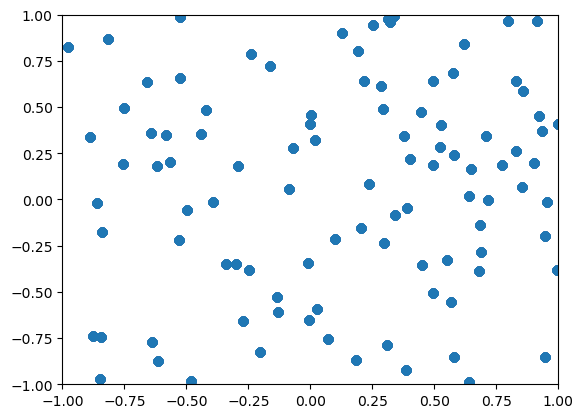

In [12]:
N = 100
runs = 100
random.seed(10)

output_dict, output_info_list = create_time_series_dict(N, runs, a = 1, b = -1, dim = 2, dist = 'uniform',
                                                        show_plot = False, debug = False)

### B. Add in change point from Complete Graph and Perturbations

#### Complete Graph as Change Point

One method for generating change point with `generate_graph`

In [13]:
N = 100
runs = 100
random.seed(10)

graph_changepoint = generate_graph(show_plot = False, from_graph = True, debug = False,
                                   G = nx.complete_graph(N), points = output_info_list[0])
# Note: output_info_list = [samps, connect_mat, connect_mat_dist]
output_dict_change = create_changepoint_time_series_dict(dict(output_dict), output_info_list[0], output_info_list[2],
                                    graph_changepoint, N, runs, debug = False, show_plot = False)

#### Calculate Raw Means and Raw Norms of Time Series (i.e. window size h = 0)
Note change at t = 100

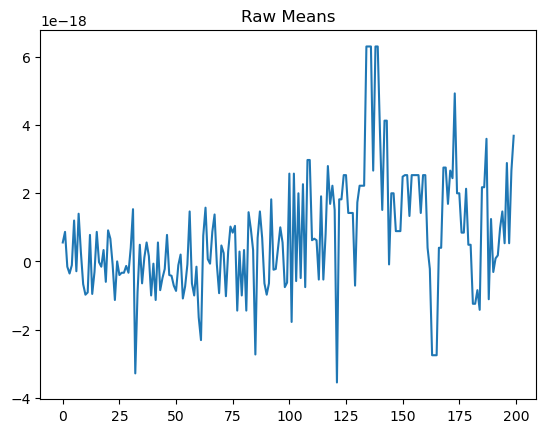

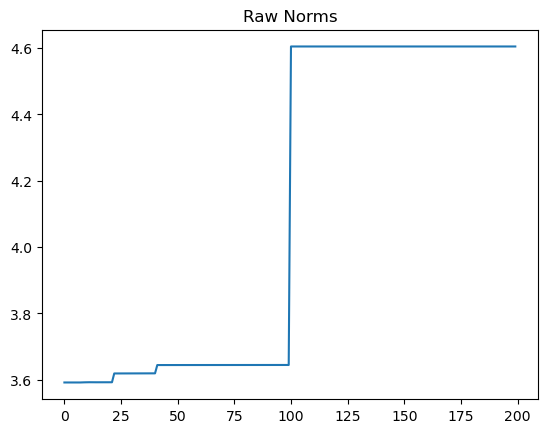

In [14]:
# list of laplacians
output_laps = [output_dict_change[i][1] for i in output_dict_change] # get list from dictionary
mat_log_dict, mat_logs, means, norms = loop_calc_matrix_logs(output_laps, start = 0, end = len(output_laps))

#### Calculate consecutive differences of matrix logs from 3.3 & Change Point Detection Plots
Note means are about 0, and spike at t = 100 shows change point

Means: t= 3.543693116725422e-18 , Max: 142


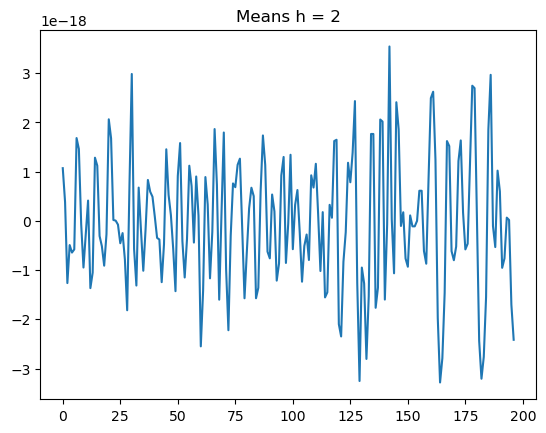

Norms: t= 3.6768373919648383 , Max: 98


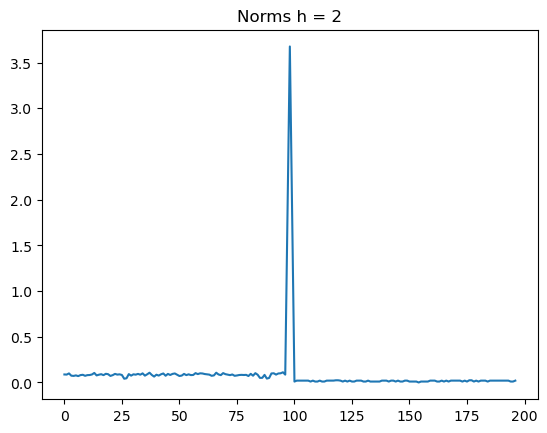

In [15]:
h = 2
means_diff_list, norms_diff_list = calc_diff_logs(mat_logs, h = h, debug = False)

### C. Add in change point from Different Orientation of Points
Change from complete graph to use from different distribution (2D vs 3D vs 4D vs 5D square, circle instead of square, sphere, etc.)

Alternate method for generating change point with `knn_graph_from_sample`

#### 4D unit square as change point

In [16]:
N = 100
runs = 100
random.seed(10)

new_samps, new_connect_mat, new_connect_mat_dist, new_graph_changepoint = knn_graph_from_sample(N, dim = 4, 
                                                                                                show_plot = False,
                                                                                                debug = False)
# how to account for using different points sampled?? just use new points
new_output_dict_change = create_changepoint_time_series_dict(dict(output_dict), new_samps, new_connect_mat_dist, 
                                                             new_graph_changepoint, N, runs, show_plot = False,
                                                             debug = False)

#### Calculate Raw Means and Raw Norms of Time Series (i.e. window size h = 0)
Note change at t = 100

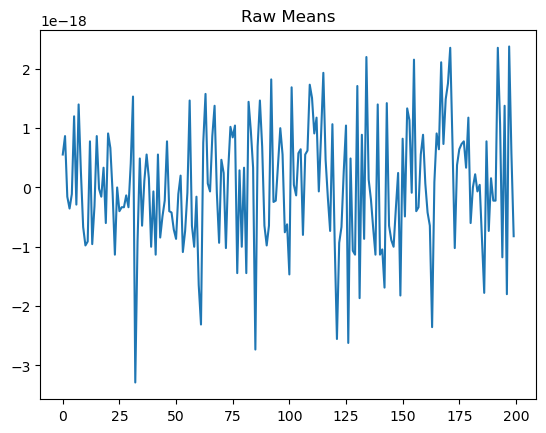

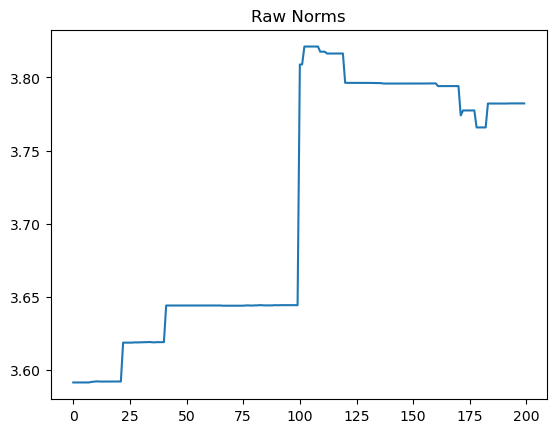

In [17]:
# list of laplacians
new_output_laps = [new_output_dict_change[i][1] for i in new_output_dict_change] # get list from dictionary
new_mat_log_dict, new_mat_logs, new_means, new_norms = loop_calc_matrix_logs(new_output_laps, 
                                                                             start = 0, end = len(new_output_laps))

#### Calculate consecutive differences of matrix logs from 3.3 & Change Point Detection Plots
Note means are about 0, and spike at t = 100 shows change point

Means: t= 2.9848953170263925e-18 , Max: 30


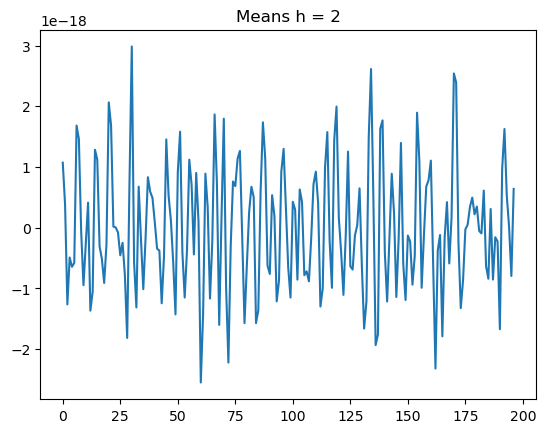

Norms: t= 2.2629340863997696 , Max: 98


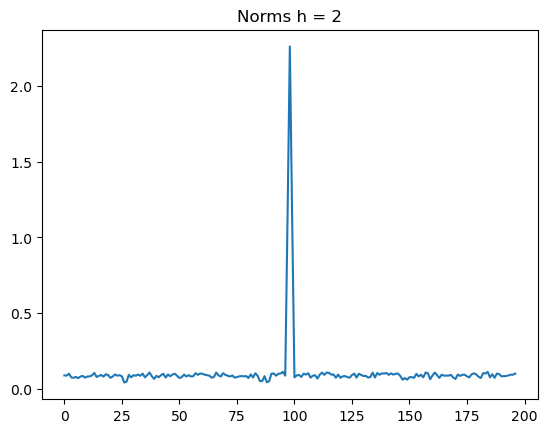

In [18]:
h = 2
new_means_diff_list, new_norms_diff_list = calc_diff_logs(new_mat_logs, h = h, debug = False)

## V. Future Work

Run `loop_calc_matrix_logs` and `calc_diff_logs` on list of time series of graph laplacians to generate change point detection plots (rather than on simulated data)

## VI. Additional Functions for Use with Dictionaries for Simulations

In [19]:
# def loop_calc_matrix_logs_both(ts_dict, start = 0, end = 1, just_lap = False, show_plot = True):
#     """
#     Same as `loop_calc_matrix_logs` but also accepts dictionary as input
#     Runs calc_matrix_logs on list of laplacians,
#     works with both generated dictionary of time series and list of laplacians
#     Parameters:
#         ts_dict: if just_lap = False:
#                     dictionary of time series from create_time_series_dict
#                  if just_lap = True:
#                     list of time series of laplacian in dense matrix format (if not dense, will be converted to dense)
#         start: time t to start adding to dictionary time series (usually 0)
#         end: time t to end adding to dictionary time series (usually number of runs)
#         show_plot: True will plot raw means and raw norms
#     Returns:
#         if just_lap = False:
#             ts_dict: input dictionary with raw matrix log, raw mean, and raw norm appended at each time t
#         if just_lap = True:
#             list_output: dictionary of time series of raw matrix log, raw mean, and raw norm (for each individual matrix)
#         means: list of raw means
#         norms: list of raw norms
#     """
#     means = [-1]*len(ts_dict)
#     norms = [-1]*len(ts_dict) # use norms, should be close to 0
#     mat_logs = [-1]*len(ts_dict)
    
#     if just_lap == True:
#         list_output = {0: []}
#         for i in range(start, end):
#             mat_logs[i], means[i], norms[i] = calc_matrix_logs(ts_dict[i])
#             list_output[i] = [mat_logs[i], means[i], norms[i]]
#     elif just_lap == False:
#         for i in range(start, end):
#             # add to existing dictionary
#             mat_logs[i], means[i], norms[i] = calc_matrix_logs(ts_dict[i][1])
#             ts_dict[i] = ts_dict[i] + [mat_logs[i], means[i], norms[i]]
    
#     if show_plot == True:
#         plt.plot(means) #all close to zero
#         plt.title('Raw Means')
#         plt.show()

#         plt.plot(norms) #all very similar
#         plt.title('Raw Norms')
#         plt.show()
    
#     if just_lap == True:
#         return list_output, mat_logs, means, norms
#     if just_lap == False:
#         return ts_dict, mat_logs, means, norms

In [20]:
# def calc_diff_logs_both(ts_dict, h = 1, debug = False):
#     """
#     Same as `calc_diff_logs` but accepts dictionaries as input.
#     Calculates distance G(x,h) as defined in section 3.3
#     Parameters:
#         ts_dict: dictionary from generate_graph_time_series() and loop_calc_matrix_logs_both()
#             Key is the time t (int)
#             Value is a list: [0] new graph, [1] laplacian matrix of new graph, [2] adjacency matrix of new graph,
#                                 [3] raw matrix log, [4] raw mean, [5] raw norm
#         h: window size    
#     Returns:
#         list of mean differences (G(x,h)) and norm differences (||G(x,h)||_2) at each time t
#     """
#     # differences is test statistic of window from section 3.3
#     means_diff = [-1]*(len(ts_dict)-2*h+1) # should be 0
#     norms_diff = [-1]*(len(ts_dict)-2*h+1) # use norms, should be close to 0

#     for i in range(h-1, len(ts_dict)-h):
#         if debug == True:
#             print("**x: ", i)
#         pos_diff = 0
#         neg_diff = 0
#         for j in range(i-h+1, i+1):
#             if debug == True:
#                 print("j: ", j)
#             pos_diff = pos_diff + 1/h * ts_dict[j][3]
#         for k in range(i+1, i+h+1):
#             if debug == True:
#                 print("k: ", k)
#             neg_diff = neg_diff - 1/h * ts_dict[k][3]
#         diff = pos_diff + neg_diff
#         means_diff[i-h+1] = (diff).mean() #diff means at each time
#         norms_diff[i-h+1] = lg.norm(diff, 2) #diff norms at each time
#     return means_diff, norms_diff

In [21]:
# """
# calls to dictionary input functions
# """

# mat_log_dict_both, mat_logs_both, means_both, norms_both = loop_calc_matrix_logs_both(dict(output_dict),
#                                                                        start = 0, end = len(output_dict))
# calc_diff_logs_both(mat_log_dict_both, h = 1, debug = True)